# Titanic - Data cleaning and feature engineering

In [1]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib widget
%matplotlib inline

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import chart_studio.plotly as py
import chart_studio.tools as tls

# username = 'your_username'  # Replace with your Chart Studio username
# api_key = 'your_api_key'  # Replace with your Chart Studio API key
# # Set up authentication credentials
# tls.set_credentials_file(username=username, api_key=api_key)


from ipywidgets import interact

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

------------------

# Load and explore the data

In [2]:
# Load the data
train = pd.read_csv("titanic_datasets/train.csv")
test = pd.read_csv("titanic_datasets/test.csv")

# concatenate train and test in same dataframe to perform data cleaning and feature engineering n both parts.
df = pd.concat([train, test], ignore_index = True, sort = False)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


A brief description of the variables in this dataset is presented below. For more detailed information consult the source at Kaggle: Titanic-Machine Learning from Disaster. These variables provide information about different aspects of the passengers on the Titanic, such as their demographics, family relationships, ticket details, and survival outcome.



| Variable    | Description                                               | Comments                                           |
|-------------|-----------------------------------------------------------|----------------------------------------------------|
| PassengerId | Unique identifier for each passenger                      | Used in the kaggle submission                      |
| Survived    | Survival status (0 = No, 1 = Yes)                         | Rows with NaNs used for test prediction for Kaggle |
| Pclass      | Ticket class (1 = 1st class, 2 = 2nd class, 3 = 3rd class)|                                                    |
| Name        | Passenger's name                                          | It containis the title                             |
| Sex         | Passenger's sex:                                          | string "male" or "female"                          |
| Age         | Passenger's age in years                                  |                                                    |
| SibSp       | Number of siblings and/or spouses aboard the Titanic      |                                                    |
| Parch       | Number of parents and/or children aboard the Titanic      |                                                    |
| Ticket      | Ticket code,                                              | The companions have same ticket code               |
| Fare        | Fare corresponding to the ticket code                     | Repeated for passengers with the same ticket code  |
| Cabin       | Cabin label and number                                    | Some passengers have more than one cabin some missing|  | Embarked    | Port of embarkation                                       | (C = Cherbourg, Q = Queenstown, S = Southampton)   |


Check the missing values and data types


In [3]:
nan_counts = df.isna().sum().sort_values(ascending = False)
summary = pd.concat([df.info(), nan_counts], axis=0)
print(summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
PassengerId       0
Pclass            0
Name              0
Sex               0
SibSp             0
Parch             0
Ticket            0
d

------------------------

# Data processing steps

* Map "Sex" to "is_male", to use this variable in correlation plots and in ML models.
* Map 'Embarqued' to Embarqued_code{1,2,3}. reserve the zero for NaN.
* Split the variable "Ticket" into "Ticket_preffix" and "Ticket_n"
* Group the duplicated Ticket values and count the number of people that traveled together including friends, maids, and nannies, and create the variable "Companions".
* Create the variable "FamilySize" by combining the variables "SibSp" and "Parch".
* Extract the variable "Title" from the variable "Name" and categorize.
* Map "Fare" to "Fare_level": {1,2,3,4,5,6,7,8,9,10}
* The dirtiest variable 'Cabin' -> split it into ['Cabin_label', 'Cabin_n', 'n_of_Cabins'].
* Map the variable "Age" into "Age_group"

## Sex
Encode the variable "Sex" to "Is_male", 1 for male, 0 for female. This step is required because we plan to use scikit-learn decision tree-based ML algorithms and It requires the encoding of categorical variables (see scikit-learn 1.3.0: Decision tree).

In [4]:
# Mapping Sex bolean
df['Is_male'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

## Mapping Embarked

Clean the variable for the port of embarkation, "Embarked". First, we fill only two NaN values with the true value we found on Google, then encode the variable to numerical values. The values C = Cherbourg, Q = Queenstown, and S = Southampton, will be mapped to 1 = C, 2 = Q, and 3 = S.

In [5]:
# Check the entries with NaN vales.
df.loc[df['Embarked'].isna(),:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_male
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0


We see both passengers share the variable values, Sex = female, Pclass = 1, they were in the same Cabin = B28, and the Ticket number is the same Ticket = 113572. Do you think it is a coincidence? I think Not! If we try to see the number of passengers with these characteristics will guess the Embarked being either C or S. Alternatively we can google search for it and find that: Mrs. Stone boarded the Titanic in Southampton on 10 April 1912 and was traveling in first class with her maid Amelie Icard. She occupied cabin B-28.([encyclopedia titanica](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html))

In [6]:
# filter and count the most frequent values
df.loc[(df['Sex'] == 'female') & (df['Pclass'] == 1), 'Embarked'].value_counts(dropna= False)

Embarked
C      71
S      69
NaN     2
Q       2
Name: count, dtype: int64

In [7]:
# Fill the NaN and map Embarked to numerical codes
df.loc[df['Embarked'].isna(), 'Embarked'] = 'S'  # (Encyclopedia titanica)
df['Embarked_code'] = df['Embarked'].map( {'C': 1, 'Q': 2, 'S': 3} ).astype(int)

## Split the variable Ticket

Split the "Ticket" into the variables "Ticket_preffi" and "Ticket_number"

In [8]:
# split the column 'Ticket'
Ticket_split = []
Ticket_len = []
for i in df['Ticket'].index:
    splitted = df.loc[i,'Ticket'].split(' ')
    Ticket_split.append(splitted)
    length = len(splitted)
    Ticket_len.append(length)
    
df['Ticket_split'] = Ticket_split
df['Ticket_len'] = Ticket_len

# df[['Ticket_len']].value_counts()
# df.loc[df['Ticket_len'] > 2, :] We can see tome typo errors.

# Create columns Ticket_preffix and Ticket_number
ticket_preffix = []
ticket_number = []
for i in df['Ticket'].index:
    ticket_parts = df.loc[i, 'Ticket_split']
    number = ticket_parts[-1]
    ticket_number.append(number)
    length = df.loc[i, 'Ticket_len'].item()
    if length > 1:
        preffix = ''.join(ticket_parts[0:-1])
        ticket_preffix.append(preffix)
    else:
        ticket_preffix.append('blanck')
        
df['Ticket_preffix'] = ticket_preffix
df['Ticket_number'] = ticket_number
# drop unnecessary columns created
df.drop(columns=['Ticket_split', 'Ticket_len'], inplace=True)

df.Ticket_preffix.unique()

array(['A/5', 'PC', 'STON/O2.', 'blanck', 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'A4.', 'C', 'SOTON/O.Q.',
       'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'F.C.C.', 'W/C',
       'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S', 'SC/AHBasle',
       'A/4', 'WE/P', 'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2',
       'S.C./PARIS', 'C.A./SOTON', 'SC/A.3', 'STON/OQ.', 'SC/A4', 'AQ/4',
       'A.2.', 'LP', 'AQ/3.'], dtype=object)

We can visualize the variety of ticket prefix values and try to find a relationship with the port of embarkation.

In [9]:
df_grouped = df.groupby(['Ticket_preffix', 'Embarked']).agg({'Survived': ['sum', lambda x: x.count() - x.sum()]})
df_grouped.columns = ['Survived', 'Non-Survived']
df_grouped['Count'] = df.groupby(['Ticket_preffix', 'Embarked']).size()
print(df_grouped)

                         Survived  Non-Survived  Count
Ticket_preffix Embarked                               
A./5.          S              0.0           2.0      3
A.2.           S              0.0           0.0      1
A.5.           S              0.0           2.0      3
A/4            S              0.0           3.0      6
A/4.           S              0.0           3.0      3
A/5            S              1.0           9.0     12
A/5.           Q              0.0           1.0      1
               S              1.0           5.0      9
A/S            S              0.0           1.0      1
A4.            S              0.0           1.0      1
AQ/3.          Q              0.0           0.0      1
AQ/4           Q              0.0           0.0      1
C              S              2.0           3.0      8
C.A.           C              0.0           0.0      1
               S             13.0          14.0     45
C.A./SOTON     S              0.0           1.0      1
CA        

The column "Tiket_prefix" has some typo errors and seems to be related to the 'Embarked' info. Most of the values are blank and maybe it doesn't worth analyzing the survival probability with a ML model.

## Companions
Moreover, we already observed that the variable "Ticket_number" has some duplicated entries. Some passengers share the ticket number because they are together. They can have a relationship with an employee or service like a maid or a nanny, or they can be close friends. These relationships were not all captured in the variables "SibSp" and "Parch". See, for example, the case of Mrs. Stone boarded that was traveling with her maid Amelie Icard and both survived.([encyclopedia titanica](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html)).

We can extract implicit information from the duplicated values in the variable "Ticket" and create a new variable to describe it. Here we engineer the new variable "Companions" describing the number of companions or fellow passengers for each individual. Maybe this number makes some impact on the survival probability when we use ML algorithm to predict the "Survived" values in the test dataset.



In [10]:
n_alone , n_duplicates = df['Ticket'].duplicated(keep=False).astype(int).value_counts()

print("Number of duplicated ticket values:", n_duplicates)
print("Number of non-duplicated ticket values:", n_alone)

Number of duplicated ticket values: 596
Number of non-duplicated ticket values: 713


We can check the distribution of the number of companions.

In [11]:
df['Companions'] = df['Ticket'].duplicated(keep=False).astype(int) * df.groupby('Ticket')['Ticket'].transform('count') -1 
df.loc[df['Companions'] == -1, 'Companions'] = 0
df['Companions'].value_counts()

Companions
0     713
1     264
2     147
3      64
4      35
6      35
5      24
7      16
10     11
Name: count, dtype: int64

## Family size

The new variable "Family size" is created with the sum of variables "SibSp" and "Parch" to describe the family structure aboard for each passenger. We are creating a correlated variable why? We can investigate the frequency of "Survived" as a function of the total number of family members. Moreover, tree-based models have a feature selection internal algorithm that chose the most relevant variables to the prediction of the target variable. Maybe the variable "Family size" can be more important than the variables "SibSp" and "Parch".

In [12]:
df['FamilySize'] = df['SibSp'] + df['Parch']
print(df[['SibSp','Parch','FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by = 'Survived'))

   FamilySize     SibSp     Parch  Survived
7           7  4.000000  3.000000  0.000000
8          10  6.727273  3.272727  0.000000
5           5  2.800000  2.200000  0.136364
4           4  2.000000  2.000000  0.200000
0           0  0.000000  0.000000  0.303538
6           6  3.250000  2.750000  0.333333
1           1  0.778723  0.221277  0.552795
2           2  0.893082  1.106918  0.578431
3           3  1.302326  1.697674  0.724138


## The new variable  "Title"
Now we will extract the passenger title information from the variable "Name". We can create the feature "Title" by extracting from the column "Name" the titles: Mr. Miss. Mrs. Dr. and others.(see also [Sina "Tinatic best working classifier"](https://www.kaggle.com/code/sinakhorami/titanic-best-working-classifier)). 

In [13]:
# get the 'Title'
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

df['Title'] = df['Name'].apply(get_title)

df_grouped = df.groupby(['Title', 'Sex']).agg({'Survived': ['sum', lambda x: x.count() - x.sum()]})
df_grouped.columns = ['Survived', 'Non-Survived']
df_grouped['Count'] = df.groupby(['Title', 'Sex']).size()
print(df_grouped)

                 Survived  Non-Survived  Count
Title    Sex                                  
Capt     male         0.0           1.0      1
Col      male         1.0           1.0      4
Countess female       1.0           0.0      1
Don      male         0.0           1.0      1
Dona     female       0.0           0.0      1
Dr       female       1.0           0.0      1
         male         2.0           4.0      7
Jonkheer male         0.0           1.0      1
Lady     female       1.0           0.0      1
Major    male         1.0           1.0      2
Master   male        23.0          17.0     61
Miss     female     127.0          55.0    260
Mlle     female       2.0           0.0      2
Mme      female       1.0           0.0      1
Mr       male        81.0         436.0    757
Mrs      female      99.0          26.0    197
Ms       female       1.0           0.0      2
Rev      male         0.0           6.0      8
Sir      male         1.0           0.0      1


clean and categorize the variable "Title", then check the counts of survived and non-survived for each categorized title.

In [14]:
# Clean the varianle Title.
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'noble')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Mrs')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Check the survival rate for the title cathegories obtained
df_grouped = df.groupby(['Title', 'Sex']).agg({'Survived': ['sum', lambda x: x.count() - x.sum()]})
df_grouped.columns = ['Survived', 'Non-Survived']
df_grouped['Count'] = df.groupby(['Title', 'Sex']).size()
# Calculate the survived/non-survived rate
df_grouped['Survival Rate'] = df_grouped['Survived'] / (df_grouped['Survived'] + df_grouped['Non-Survived'])
# Order the DataFrame by the survival rate in descending order
df_grouped = df_grouped.sort_values('Survival Rate', ascending=False)

print(df_grouped)

               Survived  Non-Survived  Count  Survival Rate
Title  Sex                                                 
noble  female       3.0           0.0      4       1.000000
Mrs    female     101.0          26.0    200       0.795276
Miss   female     129.0          55.0    262       0.701087
Master male        23.0          17.0     61       0.575000
noble  male         5.0          15.0     25       0.250000
Mr     male        81.0         436.0    757       0.156673


We can see that being a noble made a very difference in the Titanic. The other titles reflect the sex and age of the passenger. We can observe that the survival rate for a man with the title master is better than those with the title Mr, although, it can be interpreted by age whereas younger man has a better chance to survive. If we compare the survival rate of women, the passengers with the title Miss. have a lower survival chance when compared to the women with the title Mrs. whereas it can indicate the status of the woman as married or not can make a difference. But we all agree that the information about the family and the age has its own features to describe. The exclusive information we can obtain from the title feature is if the passenger owns a noble title or not.

In [15]:
df['is_noble'] = df['Title'].apply(lambda x: 1  if x =='noble'  else 0)
df['is_noble'].value_counts()

is_noble
0    1280
1      29
Name: count, dtype: int64

## Map the variable "Fare"

We can substitute the "Fare" missing value (there is only one) with the median value. To be fair we will substitute the missing fare value by the median of the fare values for the sex = male and Pclass = 3.

In [16]:
df.loc[df['Fare'].isna(),:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_male,Embarked_code,Ticket_preffix,Ticket_number,Companions,FamilySize,Title,is_noble
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,3,blanck,3701,0,0,Mr,0


In [17]:
# fill with the median Fare for the Pclass = 3 and Sex= male.
Fare_Pclass3_male = df.loc[(df['Pclass'] == 3) & (df['Sex'] == 'male'), 'Fare'].median()
df.loc[df['PassengerId'] == 1044, 'Fare'] = df.loc[(df['Pclass'] == 3) & (df['Sex'] == 'male'), 'Fare'].median()
print("medium Fare for Sex = male and Pclass=3: ", Fare_Pclass3_male)

medium Fare for Sex = male and Pclass=3:  7.8958


We can categorize the Fare in groups of equal Fare value ranges or levels. If we categorize it using interquartile, the distribution of the bins returns a weird representation because the variable "Fare" is not continuous.

In [18]:
# Calculate fare ranges with labels
n = 10
df['Fare_level'] = pd.cut(df['Fare'], n, labels=np.arange(1,n+1))
df['Fare_range'] = pd.cut(df['Fare'], n)

# Calculate survival probability for each fare level
fare_survival_grouped = df.groupby('Fare_level').agg({'Fare_range': ['first', 'count'], 'Survived': 'mean'}).reset_index()
fare_survival_grouped.columns = ['Fare_level', 'Fare_range', 'Count', 'Survival_proba']
fare_survival_grouped = fare_survival_grouped.reset_index(drop=True)
fare_survival_grouped

,Fare_level,Fare_range,Count,Survival_proba
0,1,"(-0.512, 51.233]",1071,0.318306
1,2,"(51.233, 102.466]",154,0.660377
2,3,"(102.466, 153.699]",42,0.741935
3,4,"(153.699, 204.932]",4,1.000000
4,5,"(204.932, 256.165]",21,0.636364
5,6,"(256.165, 307.398]",13,0.666667
6,7,NaN,0,NaN
7,8,NaN,0,NaN
8,9,NaN,0,NaN
9,10,"(461.096, 512.329]",4,1.000000


In the above table, four passengers with a survival probability of 100% have fare values of £ 512.33. This is the case of Mr. Mr Thomas Drake Martinez Cardeza, a wealthy banker from Germantown, PA. He boarded the Titanic with his mother Charlotte Cardeza, his manservant Gustave Lesueur and Miss. Annie Moore Ward the maid of the Cardeza Family. (see [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/titanic-survivor/thomas-cardeza.html) and [Titanic Fandom](https://titanic.fandom.com/wiki/Annie_Moore_Ward)). They occupied one of the two most luxurious suites on board (B51, B53, and B55) and paid another suit for the manservant and probably another one for their maid Annie.

In [19]:
df.loc[df['Fare_level'] == 10,["Survived", "Name", "Ticket", "Fare" ]]

,Survived,Name,Ticket,Fare
258,1.0,"Ward, Miss. Anna",PC 17755,512.3292
679,1.0,"Cardeza, Mr. Thomas Drake Martinez",PC 17755,512.3292
737,1.0,"Lesurer, Mr. Gustave J",PC 17755,512.3292
1234,NaN,"Cardeza, Mrs. James Warburton Martinez (Charlo...",PC 17755,512.3292


Let us plot the dependency of the Survival probability with the new feature "Fare_level". In the plot below we can see how the survival probability increases fast with the "Fare_level" and oscillates for values above the 4th level.

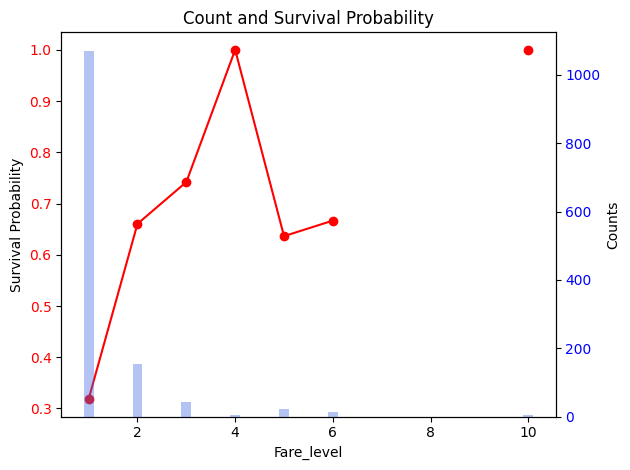

In [20]:
# Calculate the counts
variable = 'Fare_level'
counts = df[variable].value_counts()

# Calculate the probability of survival
survived = df[df['Survived'] == 1][variable].value_counts().sort_index()
not_survived = df[df['Survived'] == 0][variable].value_counts().sort_index()
survival_prob = survived / (survived + not_survived)

# Create subplots with shared x-axis
fig, ax1 = plt.subplots()   

# Plot the survival probability using scatter plot markers and lines on the left y-axis
ax1.plot(survival_prob.index, survival_prob.values, marker='o', linestyle='-', color='red')
ax1.set_ylabel('Survival Probability', color='black')
ax1.tick_params(axis='y', labelcolor='red')    

# Create a twin y-axis for the left side
ax2 = ax1.twinx()

#Plot the count bars on the right y-axis
ax2.bar(counts.index, counts.values, alpha=0.4, width=0.2, color='royalblue')
ax2.set_ylabel('Counts', color='black')
ax2.tick_params(axis='y', labelcolor='blue')

# Set the x-axis label and title
ax1.set_xlabel(variable)
plt.title('Count and Survival Probability')

# Adjust the layout of subplots
plt.tight_layout()

## Split the variable "Cabin"

This is the dirtiest column, most values are missing and some rows contain more than one value per column (more than one cabin for some passengers). Only 22% of the "Cabin" values were observed (295/1309). The Cabin information could be very informative as a proxy of the distance from the boat deck where the lifeboats were located, having a high influence on the chance of survival. But this column is not structured and has mostly missing values. To help solve this, we begin by splitting this column into three columns: ["Cabin_label", "Cabin_number", "N_of_Cabins reserved"].

Here I choose the last method and in the New variable "Cabin_label" the missing values are imputed by creating a new categorical variable "N".


In [21]:
# Get the label of the last reserved cabin if exists
# get the last cabin if exists
df['Last_cabin'] = df['Cabin'].apply(lambda x: str(x).split()[-1] if pd.notnull(x) else 'N')

# get the Cabin_label of the last cabin
pattern = r'([A-Za-z])'
df['Cabin_label'] = df['Last_cabin'].apply(lambda x: re.search(pattern, str(x)).group(1) if x != 'N' else 'N')

# Get the number of the last cabin if exists
pattern = r'(\d+)'
df['Cabin_number'] = df['Last_cabin'].apply(lambda x: re.search(pattern, str(x)) if x != 'N' else -1)

# Get the number of distinct cabins reserved by the passenger.
df['Cabin_count'] = df['Cabin'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

# drop not used columns and columns with NaN values.
df.drop(columns = ['Cabin','Last_cabin', 'Cabin_number'], inplace = True)

## Mapping Age

Here we create a new variable "Age_group" by dividing the interval of values into almost equal intervals. Here I chose the ranges 0–13 for kids, 13–30 for young, range 30–45 for a mature group, 45–60 for old. From 60 years we can classify as very old. This arbitrary categorization was chosen to obtain a good distribution of values for each category (balanced).

In [22]:
# Mapping Age
df.loc[df['Age'] <= 13, 'Age_group'] = 0 # kids
df.loc[(df['Age'] > 13) & (df['Age'] <= 30), 'Age_group'] = 1 # young
df.loc[(df['Age'] > 30) & (df['Age'] <= 45), 'Age_group'] = 2 # mature1
df.loc[(df['Age'] > 45) & (df['Age'] <= 60), 'Age_group'] = 3 # old
df.loc[(df['Age'] > 60) & (df['Age'] <= 100), 'Age_group'] = 4 # very old

# Calculate survival probability for each Age_group
age_survival_grouped = df.groupby('Age_group').agg({'Age': ['min', 'max'], 'Survived': ['mean', 'count']}).reset_index()
age_survival_grouped.columns = ['Age_group', 'Age_min' , 'Age_max', 'Survival_proba', 'Count']
age_survival_grouped

,Age_group,Age_min,Age_max,Survival_proba,Count
0,0.0,0.17,13.0,0.591549,71
1,1.0,14.00,30.0,0.366864,338
2,2.0,30.50,45.0,0.425743,202
3,3.0,45.50,60.0,0.407407,81
4,4.0,60.50,80.0,0.227273,22


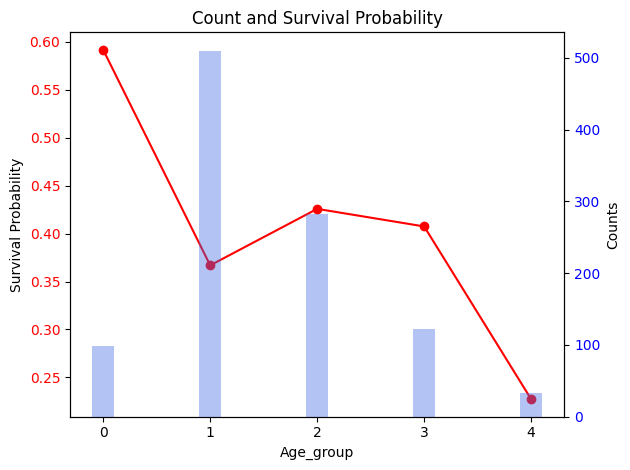

In [23]:
# Calculate the counts
variable = 'Age_group'
counts = df[variable].value_counts()

# Calculate the probability of survival
survived = df[df['Survived'] == 1][variable].value_counts().sort_index()
not_survived = df[df['Survived'] == 0][variable].value_counts().sort_index()
survival_prob = survived / (survived + not_survived)

# Create subplots with shared x-axis
fig, ax1 = plt.subplots()   

# Plot the survival probability using scatter plot markers and lines on the left y-axis
ax1.plot(survival_prob.index, survival_prob.values, marker='o', linestyle='-', color='red')
ax1.set_ylabel('Survival Probability', color='black')
ax1.tick_params(axis='y', labelcolor='red')    

# Create a twin y-axis for the left side
ax2 = ax1.twinx()

#Plot the count bars on the right y-axis
ax2.bar(counts.index, counts.values, alpha=0.4, width=0.2, color='royalblue')
ax2.set_ylabel('Counts', color='black')
ax2.tick_params(axis='y', labelcolor='blue')

# Set the x-axis label and title
ax1.set_xlabel(variable)
plt.title('Count and Survival Probability')

# Adjust the layout of subplots
plt.tight_layout()

Up to this point we only made data cleaning and feature engineering. Some missing values were filled with values obtained in external sources or we applyed a conditioned median operation to fill a small number of NaN values. This operations changes the dataset a little, but I will consider the data set just cleaned and feature engineered. In the column "Survived" the missing values corresponds to the test part (see [Kaggle Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic/data)). The columns "Age" and "Age_group" has a lot of missing vales and we can not fill it using a simple conditional median or mapping rule. Then I will save it as "titanic_eng.csv". You can download this dataset from the GitHub repo that I created for this article.

C:\Users\Pedro\.conda\envs\tfpy390\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


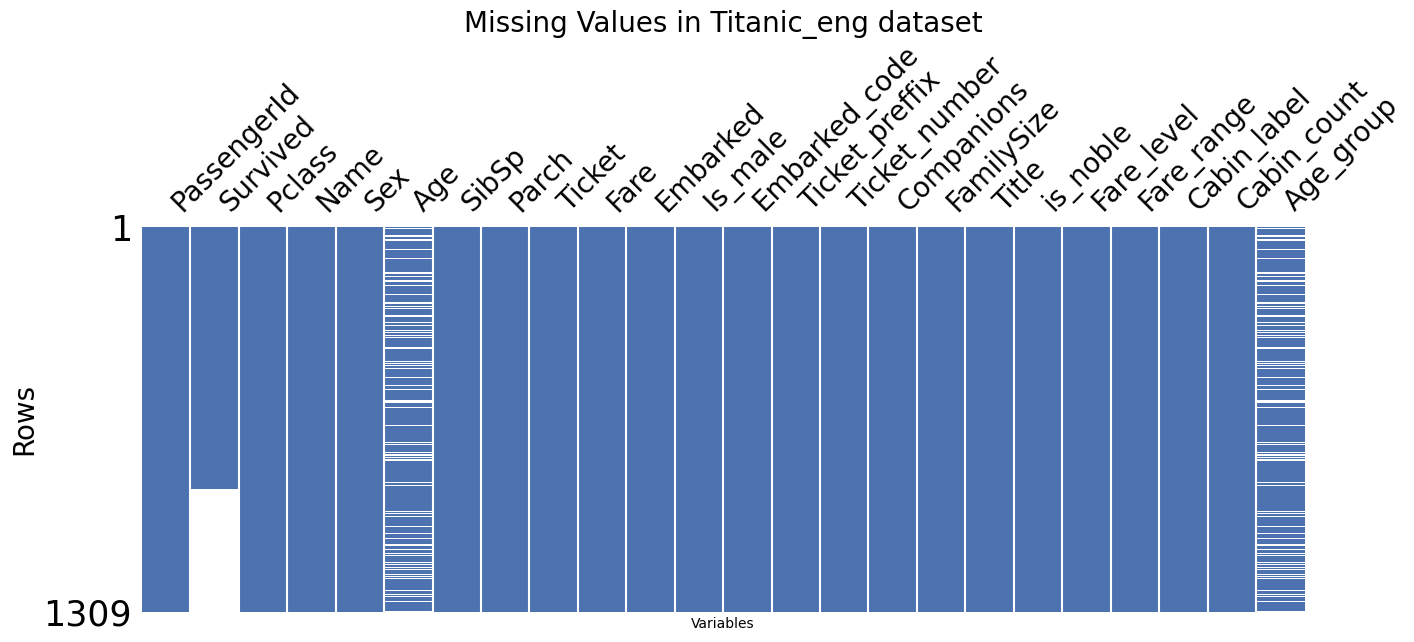

In [24]:
import missingno as msno
import matplotlib.pyplot as plt

dataframe = df

fig = plt.figure(figsize=(15, 5))  # Adjust the figsize as per your preference
ax = fig.add_subplot(111)

msno.matrix(dataframe, ax=ax, color=(0.29803922, 0.44705882, 0.69019608), fontsize=20)
ax.set_xlabel('Variables')
ax.set_ylabel('Rows', fontsize=20)
ax.set_title('Missing Values in Titanic_eng dataset', fontsize=20)

plt.show()


In [25]:
# export the dataset_eng
df.to_csv('titanic_datasets/titanic_eng.csv', index = False)

-------------------

# Exploratory Data analysis

We can make some exploratory analysis with the newly cleaned and feature-engineered Titanic dataset.

In [26]:
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Is_male', 'Embarked_code',
       'Ticket_preffix', 'Ticket_number', 'Companions', 'FamilySize', 'Title',
       'is_noble', 'Fare_level', 'Fare_range', 'Cabin_label', 'Cabin_count',
       'Age_group'],
      dtype='object')


In [27]:
def plot_countplot(variable='Sex'):
    # Calculate the counts
    counts = df[variable].value_counts()
    
    # Calculate the probability of survival
    survived = df[df['Survived'] == 1][variable].value_counts().sort_index()
    not_survived = df[df['Survived'] == 0][variable].value_counts().sort_index()
    survival_prob = survived / (survived + not_survived)

    # Create subplots with shared x-axis
    fig, ax1 = plt.subplots()   
    
    # Plot the survival probability using scatter plot markers and lines on the left y-axis
    ax1.plot(survival_prob.index, survival_prob.values, marker='o', linestyle='-', color='red')
    ax1.set_ylabel('Survival Probability', color='black')
    ax1.tick_params(axis='y', labelcolor='red')    
    
    # Create a twin y-axis for the left side
    ax2 = ax1.twinx()
    
    #Plot the count bars on the right y-axis
    ax2.bar(counts.index, counts.values, alpha=0.4, width=0.2, color='royalblue')
    ax2.set_ylabel('Counts', color='black')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # Set the x-axis label and title
    ax1.set_xlabel(variable)
    plt.title('Count and Survival Probability')
    
    # Adjust the layout of subplots
    plt.tight_layout()

# Call the interact function
interact(plot_countplot, variable=df.columns)

interactive(children=(Dropdown(description='variable', index=4, options=('PassengerId', 'Survived', 'Pclass', …

<function __main__.plot_countplot(variable='Sex')>

 Same plot but using plotly

In [28]:
def plot_Var_Survival_Volume(variable='Pclass'):
    # Calculate the counts
    counts = df[variable].value_counts()
    
    # Calculate the probability of survival
    survived = df[df['Survived'] == 1][variable].value_counts().sort_index()
    not_survived = df[df['Survived'] == 0][variable].value_counts().sort_index()
    survival_prob = survived / (survived + not_survived)

    # Create subplots with shared x-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])   
    
    # Add a scatter trace for survival probability
    fig.add_trace(go.Scatter(x=survival_prob.index, y=survival_prob.values, mode='markers+lines', name='Survival Probability', marker_color='red'), secondary_y = False)
    # Add a bar trace for counts
    fig.add_trace(go.Bar(x=counts.index, y=counts.values, name='Counts',width = 0.4, opacity=0.4, marker_color='royalblue'), secondary_y = True)
    
    # Set leayout 
    fig.update_layout(title='Count and Survival Probability',
                      height = 600,
                      width = 900,
                      font=dict(
                            family="Sans serif",
                            size=20,
                        ),
                      xaxis = dict(
                          showline=True, linewidth=2, linecolor = 'black', mirror=True,
                          showgrid=False, ticks='outside',
                      ),
                      yaxis = dict(
                          title_text="Survival Probability",
                          showline=True, linewidth=2, linecolor = 'black', mirror=True,
                          showgrid=False,
                          ticks='outside',
                          tickfont=dict(color='red')
                      ),
                      yaxis2 = dict(
                          title_text="Counts",
                          ticks='outside',
                          tickfont=dict(color='blue')
                      )
    )  


    # Show the plot
    fig.show()

# Call the interact function
interact(plot_Var_Survival_Volume, variable=df.columns)




interactive(children=(Dropdown(description='variable', index=2, options=('PassengerId', 'Survived', 'Pclass', …

<function __main__.plot_Var_Survival_Volume(variable='Pclass')>

Same plot using Dash app.py in workdir...

## Dash app - Titanic Survival probabilities - variables
[Titanic-Survival Probability for Variables](https://titanic-survivalprobability-variables.onrender.com)

Let us check the correlations between the variables of the dataset.

<Axes: >

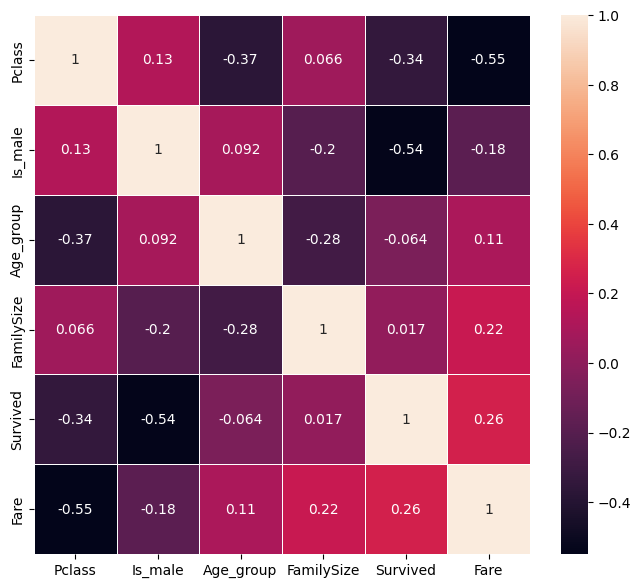

In [29]:
# print(train_data.corr())
corrMatrix = df[~pd.isna(df["Survived"])].loc[:, ['Pclass', 'Is_male', 'Age_group', 'FamilySize', 'Survived', 'Fare']].corr()
fig, ax = plt.subplots(figsize=(8,7))         # Sample figsize in inches
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)

## 4.1 Passengers with missing Cabin info

What is the profile of the passengers that has no Cabin information, or Cabin_label = N. Analyzing the distributions of the features of the passengers that were in each cabin label, we can see that the profile of the passengers with missing Cabin info is very close to the profile of all passengers, regardless of which the Cabin they were located. It can be understood as the passengers within the group with Cabin_label = N were not mostly from the lowest class social status (Pclass = 3). There are passengers from the three Pclass values with missing Cabin values. The missing cabin info is not related to a given Pclass, Sex, or Age_group, it is randomly distributed. That is why it is very hard to use this feature, with this structure, in a meaningful way.

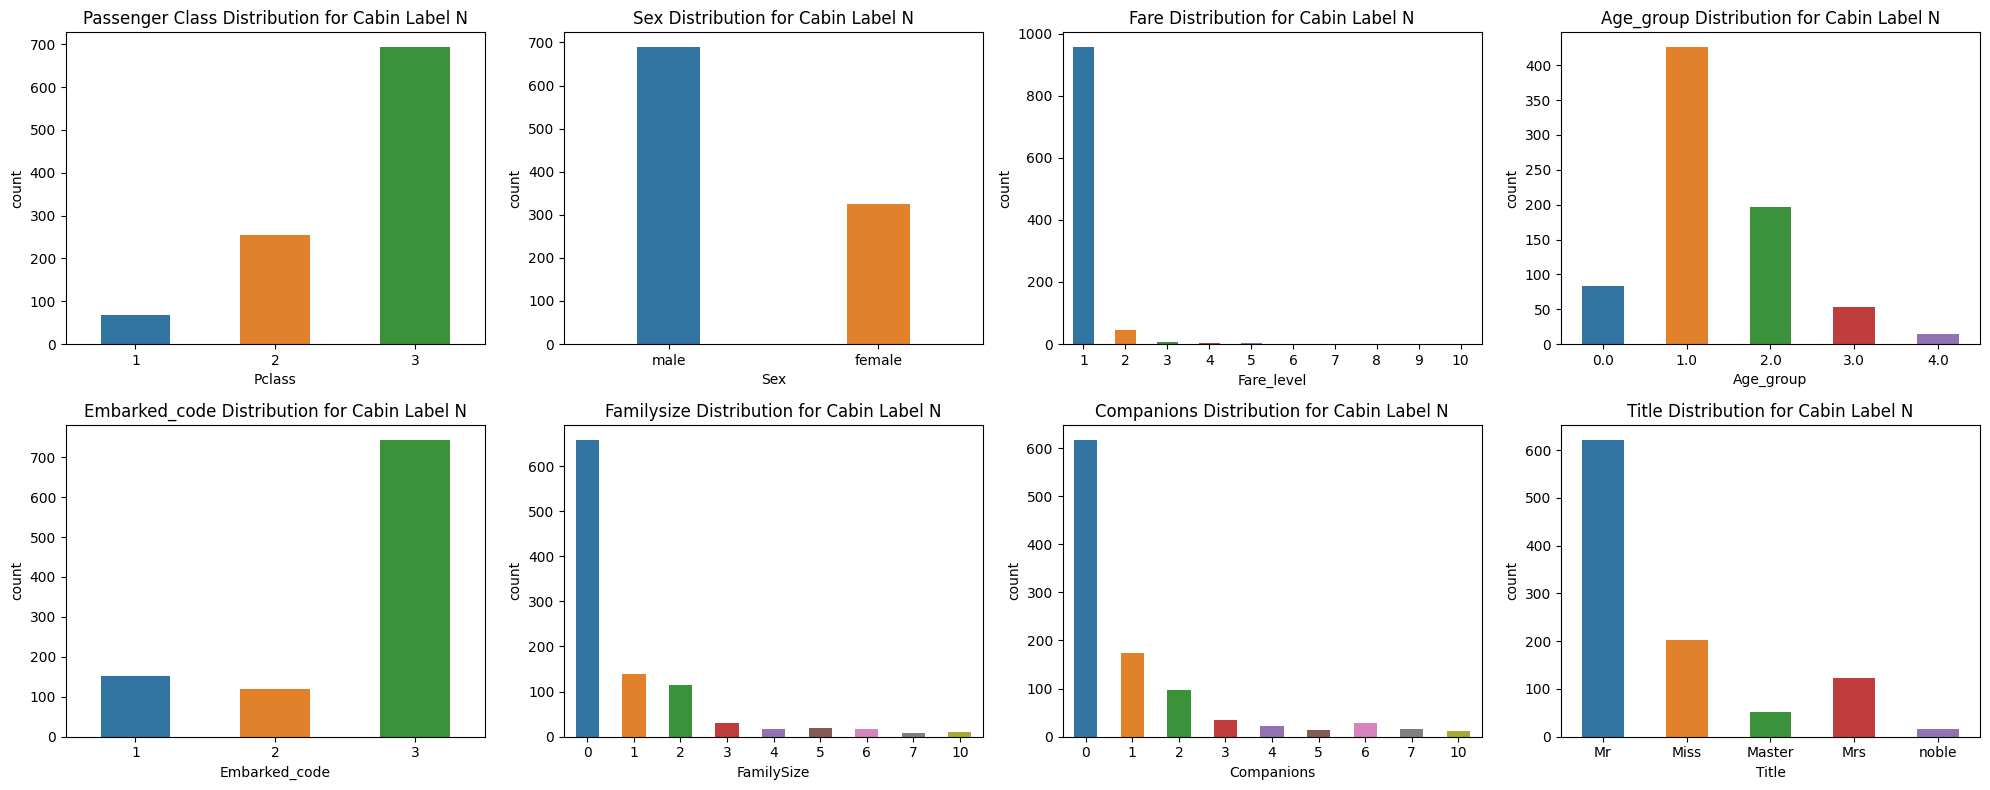

In [31]:
# Filter the DataFrame for passengers with cabin label 'N'
cabin_N_passengers = df[df['Cabin_label'] == 'N']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))

# Plot the distribution of classes
sns.countplot(x='Pclass', data=cabin_N_passengers, ax=axes[0,0], width=0.5)
axes[0,0].set_title('Passenger Class Distribution for Cabin Label N')

# Plot the distribution of sex
sns.countplot(x='Sex', data=cabin_N_passengers, ax=axes[0,1], width=0.3)
axes[0,1].set_title('Sex Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='Fare_level', data=cabin_N_passengers, ax=axes[0,2], width=0.5)
axes[0,2].set_title('Fare Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='Age_group', data=cabin_N_passengers, ax=axes[0,3], width=0.5)
axes[0,3].set_title('Age_group Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='Embarked_code', data=cabin_N_passengers, ax=axes[1,0], width=0.5)
axes[1,0].set_title('Embarked_code Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='FamilySize', data=cabin_N_passengers, ax=axes[1,1], width=0.5)
axes[1,1].set_title('Familysize Distribution for Cabin Label N')
# Plot the distribution of fare
sns.countplot(x='Companions', data=cabin_N_passengers, ax=axes[1,2], width=0.5)
axes[1,2].set_title('Companions Distribution for Cabin Label N')

# Plot the distribution of fare
sns.countplot(x='Title', data=cabin_N_passengers, ax=axes[1,3], width=0.5)
axes[1,3].set_title('Title Distribution for Cabin Label N')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

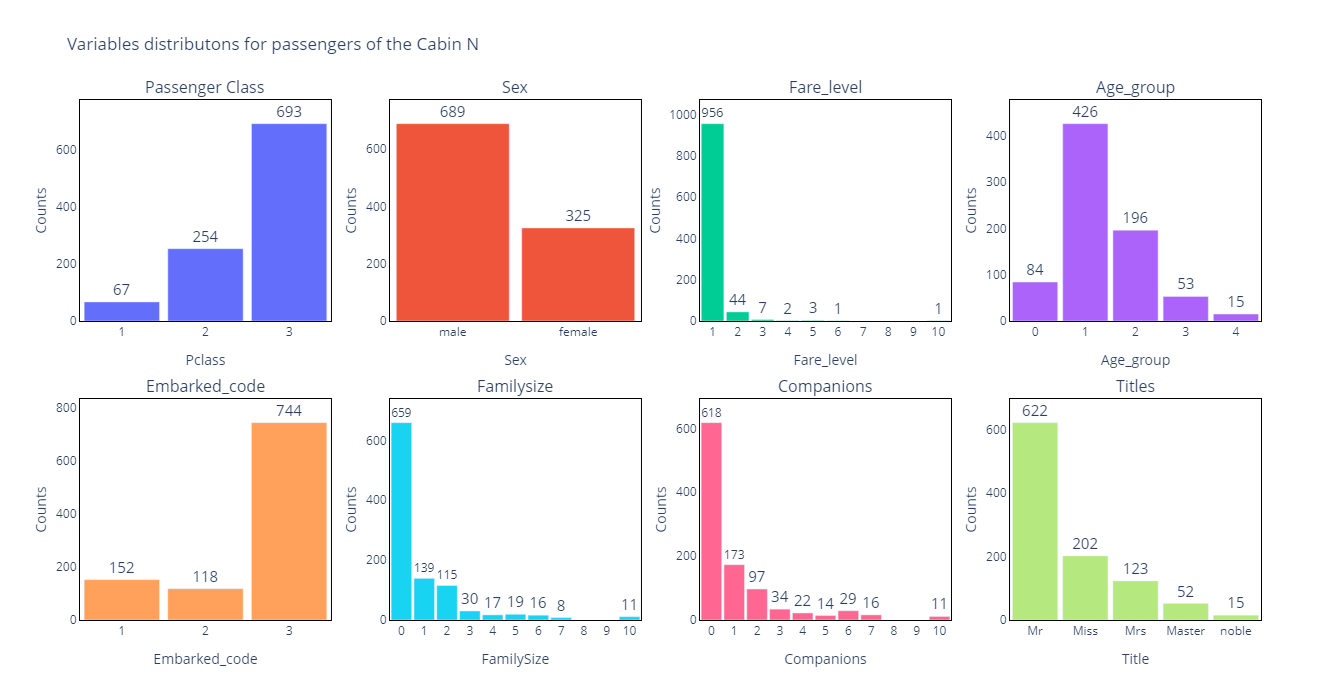

In [39]:
# Load the dataset
titanic_eng_dataset = 'https://raw.githubusercontent.com/praoiticica/Articles/main/Titanic%20Data%20Cleaning%20and%20Feature%20Engineering/titanic_datasets/titanic_eng.csv'

df = pd.read_csv(titanic_eng_dataset)

# Filter the DataFrame for passengers with cabin label 'N'
cabin_N_passengers = df[df['Cabin_label'] == 'N']

# Create subplots
fig = make_subplots(rows=2, cols=4,
                    vertical_spacing=0.15,
                    horizontal_spacing=0.05,
                    subplot_titles=[
                            'Passenger Class',
                            'Sex',
                            'Fare_level',
                            'Age_group',
                            'Embarked_code',
                            'Familysize',
                            'Companions',
                            'Titles'
                            ]
                   )

# Define the column names and subplot indices
column_names = ['Pclass', 'Sex', 'Fare_level', 'Age_group', 'Embarked_code', 'FamilySize', 'Companions', 'Title']
subplot_indices = [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4)]

# Add traces for each column
for i, column in enumerate(column_names):
    row, col = subplot_indices[i]
    counts = cabin_N_passengers[column].value_counts()
    max_count = counts.max()
    
    fig.add_trace(go.Bar(x=counts.index, y=counts.values, text = counts.values, textposition='outside', width = 0.9), row=row, col=col)
    
    # Update x-axis and y-axis titles
    fig.update_xaxes(title=column, row=row, col=col)
    fig.update_yaxes(title='Counts', row=row, col=col, title_standoff=0.1)
    fig.update_traces(textfont={'size': 15}, row=row, col=col)
    
     # Calculate the y-axis range with a small margin
    y_range = [0, max_count * 1.12]  # Adjust the margin as desired
    fig.update_yaxes(range=y_range, row=row, col=col)


# Update subplot size and spacing
fig.update_layout(
    title = 'Variables distributons for passengers of the Cabin N',
    height=700, width=1500, showlegend=False,
    plot_bgcolor='white', paper_bgcolor='white',
)

# Set x-axis tickmode to 'linear' and dtick to 1 to show all tick values
fig.update_xaxes(tickmode='linear', dtick=1)

# Update subplot axis options
for row in range(1, 3):
    for col in range(1, 5):
        fig.update_xaxes(showline=True, mirror=True, linecolor='black', row=row, col=col)
        fig.update_yaxes(showline=True, mirror=True, linecolor='black', row=row, col=col)

fig.show()

## Dash app to interact and see the results for each cabin label

## Dash plot - Titanic_Cabin Label profiles

['Variables distributons for passengers of the Cabin labels'](https://titanic-eda-cabinlabel-barplots.onrender.com/)